In [1]:
import sys
sys.path.append('..')

In [2]:
from inxai import *
from sklearn.datasets import make_classification
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import preprocessing
import sklearn
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.compose import ColumnTransformer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


# Create synthetic classification dataset

### Make classification

In [3]:
n_features = 4
X, y = make_classification(n_samples=1000, n_informative=2, n_features=n_features, n_redundant=2)
X = preprocessing.normalize(X)
X=pd.DataFrame(data=X)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## XGBoost

In [5]:
X_train.columns = ['0','1','2','3']
X_test.columns = ['0','1','2','3']
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print(accuracy_score(y_test, xgb_preds))

print(classification_report(y_test, xgb_preds))

0.9181818181818182
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       164
           1       0.90      0.95      0.92       166

    accuracy                           0.92       330
   macro avg       0.92      0.92      0.92       330
weighted avg       0.92      0.92      0.92       330



### Permutation importance

In [6]:
perm = PermutationImportance(xgb_model, random_state=1).fit(X_test, y_test)
perm_importances = perm.feature_importances_
feature_names = [str(i) for i in range(n_features)]
eli5.show_weights(perm, feature_names=feature_names)

Weight,Feature
0.3982 ± 0.0308,0
0.0006 ± 0.0071,2
0.0000 ± 0.0115,1
-0.0115 ± 0.0071,3


In [7]:
gm = GlobalFeatureMetric()

In [8]:
ct = ColumnTransformer([('_INXAI_normal_noise_perturber', NormalNoisePerturber(scale=10),X_test.columns)])


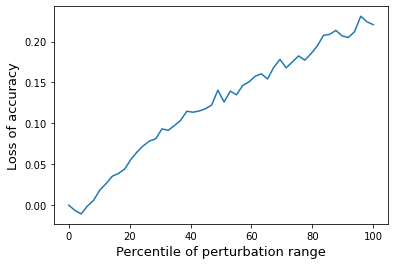

In [9]:
acc_loss = gm.gradual_perturbation(model=xgb_model, X=X_test, y=y_test, column_transformer=ct, importances_orig=perm_importances, resolution=50,  count_per_step=10)

In [10]:
from sklearn.metrics import auc
1-auc(np.linspace(0, 1, 50), acc_loss)

0.8768645640074211

### Check stability

In [11]:
shape_lips = gm.stability(X_test,generate_per_instance_importances(models=xgb_model, X=X_test, y=y_test, framework='tree_shap') )

invalid value encountered in true_divide


In [12]:
lime_lips = gm.stability(X_test,generate_per_instance_importances(models=xgb_model, X=X_test, y=y_test, framework='lime') )

invalid value encountered in double_scalars


<AxesSubplot:xlabel='variable', ylabel='value'>

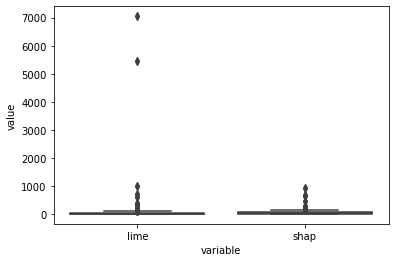

In [13]:
lip_df = pd.DataFrame({'lime':lime_lips, 'shap':shape_lips})
sns.boxplot(x="variable", y="value", data=pd.melt(lip_df))

### Check consistency

In [14]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [15]:
res = generate_per_instance_importances(models=[xgb_model, lr], X=X_test, y=y_test, framework='lime') 

In [16]:
lime_cons = gm.consistency(res)

<AxesSubplot:xlabel='variable', ylabel='value'>

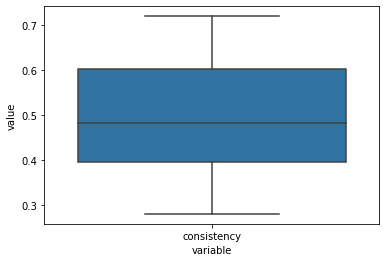

In [17]:
cons_df = pd.DataFrame({'consistency':lime_cons})
sns.boxplot(x="variable", y="value", data=pd.melt(cons_df))

In [18]:
lip_df

,lime,shap
0,1.457794,9.034679
1,9.260081,16.006450
2,13.494675,70.393396
3,11.044073,38.668417
4,23.570956,63.909578
...,...,...
325,3.231684,19.718312
326,141.250184,175.824318
327,16.599488,30.718377
328,5.850323,60.442694


# Make circles

In [19]:
X,y = sklearn.datasets.make_moons(n_samples=1000,  noise=0.08)#factor=0.5

In [20]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), y, test_size=0.33, random_state=42)
X_train.columns = ['0','1']
X_test.columns = ['0','1']

<AxesSubplot:xlabel='0', ylabel='1'>

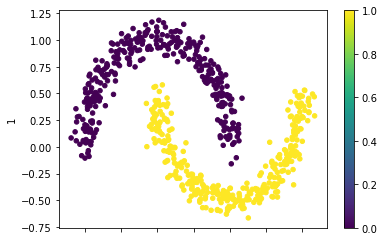

In [21]:
X_train.plot(kind='scatter',x='0', y='1',style='.', c=y_train, colormap='viridis')

In [22]:
#xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
from sklearn.svm import SVC
svc = SVC(kernel='poly',probability=True)
svc.fit(X_train, y_train)
svc_preds = svc.predict(X_test)
print(accuracy_score(y_test, svc_preds))

print(classification_report(y_test, svc_preds))

0.9363636363636364
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       168
           1       0.89      0.99      0.94       162

    accuracy                           0.94       330
   macro avg       0.94      0.94      0.94       330
weighted avg       0.94      0.94      0.94       330



In [23]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

In [24]:
print(accuracy_score(y_test, lr_preds))

print(classification_report(y_test, lr_preds))

0.8848484848484849
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       168
           1       0.88      0.89      0.88       162

    accuracy                           0.88       330
   macro avg       0.88      0.88      0.88       330
weighted avg       0.88      0.88      0.88       330



<AxesSubplot:xlabel='0', ylabel='1'>

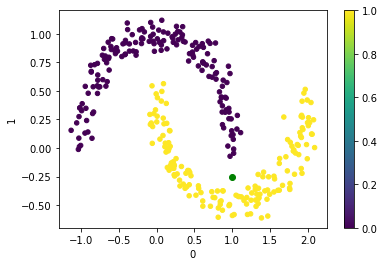

In [25]:
fig, ax = plt.subplots()
point = [1.0,-0.25]
ax.plot(point[0], point[1], 'og')
X_test.plot(kind='scatter',x='0', y='1', c=y_test, colormap='viridis', ax=ax)

In [26]:
X_test_appended = X_test.append(pd.DataFrame([point], columns=['0','1']), ignore_index=True)
y_test_appended = np.concatenate([y_test,[1]])

### Stability

In [27]:
gm = GlobalFeatureMetric()

In [28]:
shap_res=generate_per_instance_importances(models=svc, X=X_test_appended, y=y_test_appended, framework='kernel_shap')
lime_res = generate_per_instance_importances(models=svc, X=X_test_appended, y=y_test_appended, framework='lime')

Using 331 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


invalid value encountered in double_scalars


<AxesSubplot:xlabel='variable', ylabel='value'>

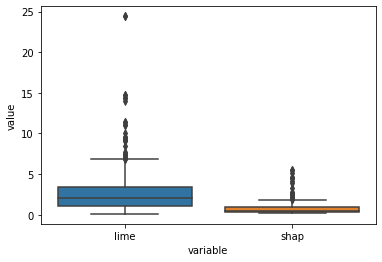

In [29]:
shape_lips = gm.stability(X_test_appended,shap_res ,epsilon=0.3)

lime_lips = gm.stability(X_test_appended,lime_res,epsilon=0.3 )

lip_df = pd.DataFrame({'lime':lime_lips, 'shap':shape_lips})
sns.boxplot(x="variable", y="value", data=pd.melt(lip_df))

### Consistency per model

Using 331 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Using 331 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


<AxesSubplot:xlabel='variable', ylabel='value'>

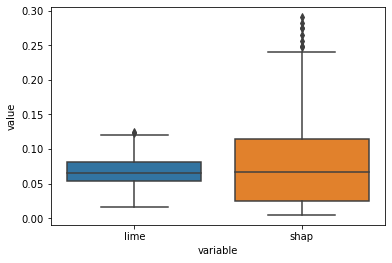

In [30]:
res_lime_con = generate_per_instance_importances(models=[svc, lr], X=X_test_appended, y=y_test_appended, framework='lime') 
res_shap_con = generate_per_instance_importances(models=[svc, lr], X=X_test_appended, y=y_test_appended, framework='kernel_shap') 
lime_cons = gm.consistency(res_lime_con)
shap_cons = gm.consistency(res_shap_con)
cons_df = pd.DataFrame({'lime':lime_cons, 'shap':shap_cons})
sns.boxplot(x="variable", y="value", data=pd.melt(cons_df))

### Per XAI consistency

Using 331 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


<AxesSubplot:xlabel='variable', ylabel='value'>

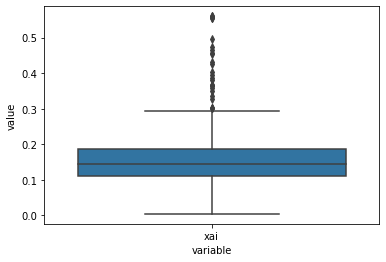

In [31]:
res_lime_con_xai = generate_per_instance_importances(models=[svc], X=X_test_appended, y=y_test_appended, framework='lime') 
res_shap_con_xai = generate_per_instance_importances(models=[svc], X=X_test_appended, y=y_test_appended, framework='kernel_shap') 
lime_shap_cons_xai = gm.consistency([res_lime_con_xai,res_shap_con_xai])
cons_df_xai = pd.DataFrame({'xai':lime_shap_cons_xai})
sns.boxplot(x="variable", y="value", data=pd.melt(cons_df_xai))

## Area under the ACCLOSS

In [32]:
import shap
import lime

In [33]:
explainer_shap = shap.KernelExplainer(svc.predict_proba, X_train)

Using 670 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [34]:
explainer_lime =lime.lime_tabular.LimeTabularExplainer(X_train,feature_names=list(X_train.columns), 
                                                       class_names=['0','1'], discretize_continuous=False)

In [35]:
shap_res_instance = explainer_shap.shap_values(X_test_appended)

In [36]:
explainer_lime.explain_instance(X_test.iloc[0],svc.predict_proba).as_list()

[('1', -0.34578533199982403), ('0', 0.006712691203399383)]

In [37]:
def expl(row):
    e = explainer_lime.explain_instance(row,svc.predict_proba).as_list()
    return [e[0][1],e[1][1]]

In [38]:
shap_res_global = pd.DataFrame(shap_res_instance[0]).apply(abs).mean()

In [39]:
lime_res_global = X_test.apply(lambda x: expl(x), axis=1, result_type='expand').apply(abs).mean()

In [40]:
ct = ColumnTransformer([('_INXAI_normal_noise_perturber', NormalNoisePerturber(scale=10),X_test_appended.columns)])

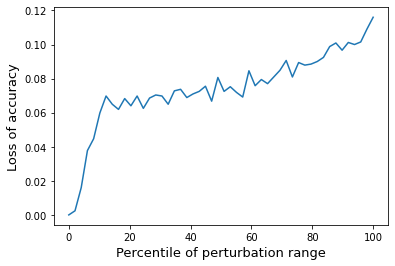

In [41]:
acc_loss_shap = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, importances_orig=shap_res_global, resolution=50,  count_per_step=10)

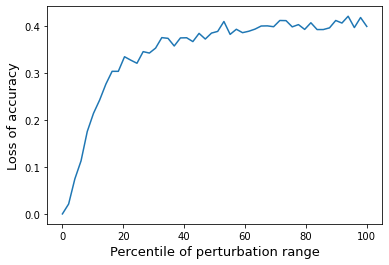

In [42]:
acc_loss_lime = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, importances_orig=lime_res_global, resolution=50,  count_per_step=10)

In [43]:
auc_df = pd.DataFrame({'lime':[1-auc(np.linspace(0, 1, 50),acc_loss_lime)], 'shap':[1-auc(np.linspace(0, 1, 50),acc_loss_shap)]})

## Results

### Combined explanation

In [44]:
cons_alpha = 0.1
lip_alpha=0.5
auc_alpha=0.4

### Single instance

In [45]:
weights = cons_alpha/cons_df.iloc[330]+lip_alpha/lip_df.iloc[330]+auc_alpha*auc_df

In [46]:
explanations_for_instance = np.array([lime_res[-1],shap_res[-1]])

In [47]:
weights.dot(explanations_for_instance)/weights.sum().sum()

,0,1
0,0.062604,0.466133


### For all instances

In [48]:
weights_df = (cons_alpha/cons_df+lip_alpha/lip_df)+auc_alpha*auc_df.values

In [49]:
r1 = weights_df['lime']*pd.DataFrame(lime_res).T
r2 = weights_df['shap']*pd.DataFrame(shap_res).T

In [50]:
ensemple_res = (r1+r2)/weights_df.sum(axis=1)

In [51]:
ens_res = ensemple_res.T.values

#### Stability 

In [52]:
ens_lips = gm.stability(X_test_appended,ens_res,epsilon=0.3)

invalid value encountered in double_scalars


<AxesSubplot:xlabel='variable', ylabel='value'>

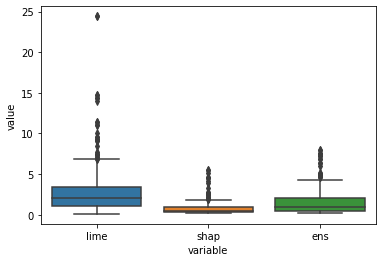

In [53]:
lip_df_fin = pd.DataFrame({'lime':lime_lips, 'shap':shape_lips, 'ens':ens_lips})
sns.boxplot(x="variable", y="value", data=pd.melt(lip_df_fin))

### ACC Loss

In [54]:
ens_res_global = pd.DataFrame(ens_res).mean()

[0.9246531845366546]

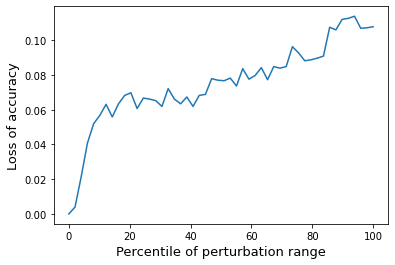

In [55]:
ens_loss_lime = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, importances_orig=ens_res_global, resolution=50,  count_per_step=10)
[1-auc(np.linspace(0, 1, 50),ens_loss_lime)]

[0.9251988408656514]

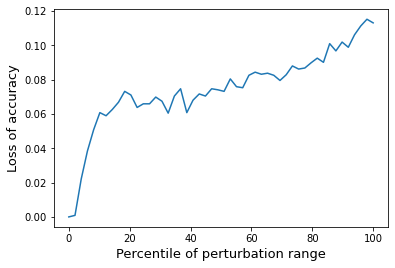

In [56]:
acc_loss_shap = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, importances_orig=shap_res_global, resolution=50,  count_per_step=10)
[1-auc(np.linspace(0, 1, 50),acc_loss_shap)]

In [57]:
[1-auc(np.linspace(0, 1, 50),acc_loss_shap)]

[0.9251988408656514]

[0.6552037733522412]

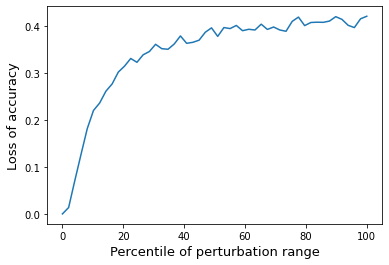

In [58]:
acc_loss_lime = gm.gradual_perturbation(model=svc, X=X_test_appended, y=y_test_appended, column_transformer=ct, importances_orig=lime_res_global, resolution=50,  count_per_step=10)
[1-auc(np.linspace(0, 1, 50),acc_loss_lime)]

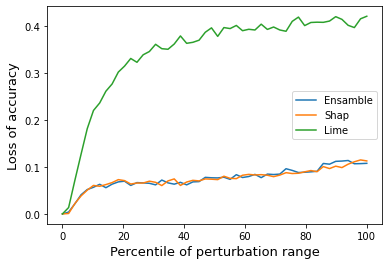

In [59]:
plt.plot(np.linspace(0, 100, 50), ens_loss_lime)
plt.plot(np.linspace(0, 100, 50), acc_loss_shap)
plt.plot(np.linspace(0, 100, 50), acc_loss_lime)
plt.xlabel('Percentile of perturbation range', fontsize=13)
plt.ylabel('Loss of accuracy', fontsize=13)
plt.legend(['Ensamble','Shap','Lime'])

## Consistency od choosen explanation mechanism

In [60]:
src1=pd.DataFrame(res_shap_con[0]).apply(lambda x: x*weights_df['shap'],axis=0)

In [61]:
src2=pd.DataFrame(res_shap_con[1]).apply(lambda x: x*weights_df['shap'],axis=0)

<AxesSubplot:xlabel='variable', ylabel='value'>

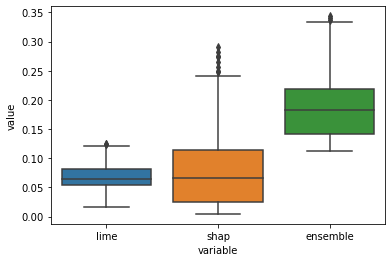

In [62]:
lime_cons = gm.consistency(res_lime_con)
shap_cons = gm.consistency(res_shap_con)
shap_cons_dd =gm.consistency([src1.values,src2.values])
cons_df_ens = pd.DataFrame({'lime':lime_cons, 'shap':shap_cons, 'ensemble':shap_cons_dd})
sns.boxplot(x="variable", y="value", data=pd.melt(cons_df_ens))